In [213]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
from PcmPy.tmp__inference_cka import fit_CKA_individ, fit_CKA_group_crossval
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



## Bimanual

decompose the bimanual pattern into contra, ipsi, and interaction components

### load data

In [207]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

labels = ['flx_flx',    'flx_flxup',   'flx_extup',   'flx_ext',   'flx_extdn',   'flx_flxdn',
          'flxup_flx',  'flxup_flxup', 'flxup_extup', 'flxup_ext', 'flxup_extdn', 'flxup_flxdn',
          'extup_flx',  'extup_flxup', 'extup_extup', 'extup_ext', 'extup_extdn', 'extup_flxdn',
          'ext_flx',    'ext_flxup',   'ext_extup',   'ext_ext',   'ext_extdn',   'ext_flxdn',
          'extdn_flx',  'extdn_flxup', 'extdn_extup', 'extdn_ext', 'extdn_extdn', 'extdn_flxdn',
          'flxdn_flx',  'flxdn_flxup', 'flxdn_extup', 'flxdn_ext', 'flxdn_extdn', 'flxdn_flxdn']
cmap = 'RdBu_r'
ncond = 36

# load dataset:
file_path_save = os.path.join(analysisDir, f'pcm_dataset_bimanual_{region}.npz')
D = np.load(file_path_save, allow_pickle=True)
D = D['Y'].tolist()

# data g matrix:
N = len(D)
print(f'Number of subjects: {N}')
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

# plt.rcParams.update({'font.size': 6})
# # visualize the estimated G:
# G_mean = np.mean(G_hat, axis=0)
# plt.figure(figsize=(6,6))
# vmin = -np.max(np.abs(G_mean))
# vmax = np.max(np.abs(G_mean))
# plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
# # draw lines every 6 conitions:
# for i in range(1,6):
#     plt.axhline(y=i*6-0.5, color='black', linestyle='--', linewidth=0.5)
#     plt.axvline(x=i*6-0.5, color='black', linestyle='--', linewidth=0.5)
# plt.colorbar()
# plt.title(f'Estimated G {region}')
# plt.xlabel('Conditions')
# plt.ylabel('Conditions')
# plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
# plt.yticks(ticks=np.arange(ncond), labels=labels)
# plt.tight_layout()
# plt.show()



Number of subjects: 24


### build and fit the components

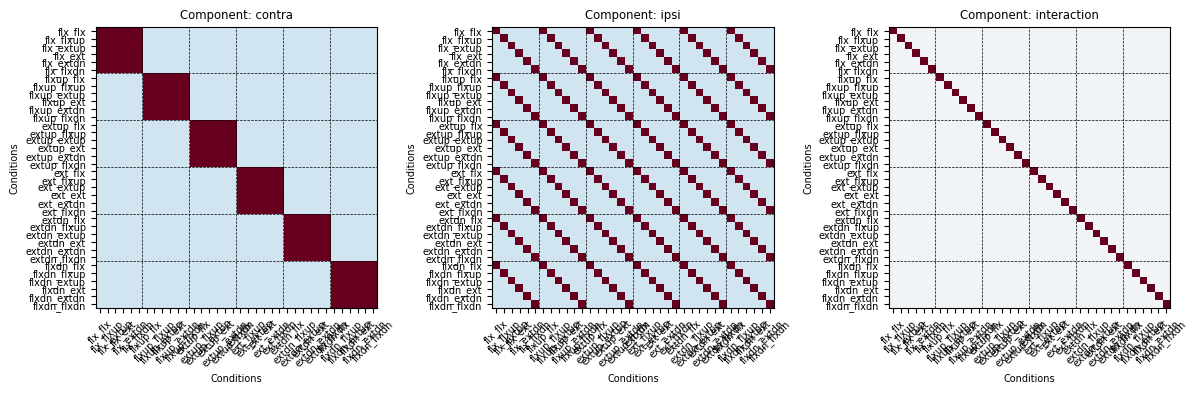

Fitting CKA individual...
Fitting PCM individual...


In [208]:
ncond = 36
G_model = {}

# Contra component:
cov = np.kron(np.eye(6), np.ones((6, 6)))
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['contra'] = cov

# Ipsilateral component:
cov = np.kron(np.ones((6, 6)), np.eye(6))
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['ipsi'] = cov  

# interaction term:
cov = np.eye(ncond)
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['interaction'] = cov

M = []
M.append(pcm.ComponentModel('all', [G_model['contra'],G_model['ipsi'], G_model['interaction']]))

# visualize model components:
ncomponent = len(G_model.keys())
fig, axes = plt.subplots(1, ncomponent, figsize=(4*ncomponent,4))
for i, key in enumerate(G_model.keys()):
    vmin = -np.max(np.abs(G_model[key]))
    vmax = np.max(np.abs(G_model[key]))
    axes[i].imshow(G_model[key], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # draw lines every 6 conitions:
    for j in range(1,6):
        axes[i].axhline(y=j*6-0.55, color='black', linestyle='--', linewidth=0.5)
        axes[i].axvline(x=j*6-0.55, color='black', linestyle='--', linewidth=0.5)
    axes[i].set_title(f'Component: {key}')
    axes[i].set_xlabel('Conditions')
    axes[i].set_ylabel('Conditions')
    axes[i].set_xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
    axes[i].set_yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

# fit CKA individual:
print('Fitting CKA individual...')
T_CKA_ind, theta_CKA_ind, AIC = fit_CKA_individ(D, M, verbose=False, AIC=True)

# fit PCM individual:
print('Fitting PCM individual...')
T_PCM_ind, theta_PCM_ind = pcm.fit_model_individ(D, M, fit_scale=False, verbose=False)



### variance of components

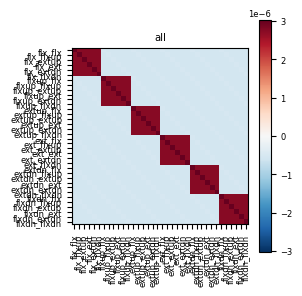

4


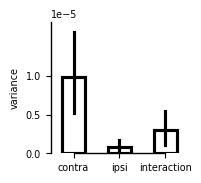

In [212]:
theta = theta_PCM_ind

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(3*nmodels,3))
th = []
for m in range(nmodels):
    th_tmp = np.exp(theta[m])
    th_tmp = np.median(th_tmp, axis=1)
    th_tmp = np.log(th_tmp)
    th.append(th_tmp)
    
    G_pred = M[m].predict(th[m][:M[m].n_param])[0]
    vmin = -np.max(np.abs(G_pred))
    vmax = np.max(np.abs(G_pred))
    ax.imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.set_xticks(list(range(ncond)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(list(range(ncond)))
    ax.set_yticklabels(labels)
    ax.set_title(f'{M[m].name}')
    plt.colorbar(ax.imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.tight_layout()
plt.show()

print(len(theta[0]))

# variance of components:
var_contra = np.trace(G_model['contra'])/ncond * np.exp(theta[0][0])
var_ipsi = np.trace(G_model['ipsi'])/ncond * np.exp(theta[0][1])
var_interaction = np.trace(G_model['interaction'])/ncond * np.exp(theta[0][2])

# boxplot:
var_df = {'sn': [], 'component': [], 'variance': []}
for i in range(var_contra.shape[0]):
    # total_var = var_contra[i] + var_ipsi[i] + var_interaction[i]
    total_var = 1

    var_df['sn'].append(i)
    var_df['component'].append('contra')
    var_df['variance'].append(var_contra[i]/total_var)
    
    var_df['sn'].append(i)
    var_df['component'].append('ipsi')
    var_df['variance'].append(var_ipsi[i]/total_var)
    
    var_df['sn'].append(i)
    var_df['component'].append('interaction')
    var_df['variance'].append(var_interaction[i]/total_var)

    # total_var = np.trace(G_hat[i,:,:])/ncond
    # var_df['sn'].append(i)
    # var_df['component'].append('total')
    # var_df['variance'].append(total_var)
var_df = pd.DataFrame(var_df)

plt.rcParams.update({'font.size': 7})
fig, ax = plt.subplots(figsize=(2,2))
sns.barplot(x='component', y='variance', data=var_df, width=0.5, color='k', fill=False, ax=ax)
ax.set_yticks(np.array([0, 0.5, 1.0])*1e-5)
ax.set_ylim(0, 1.7e-5)
plt.tight_layout()
utils.please.make_it_pretty(ax=ax)
ax.set_xlabel('')
plt.savefig(f'../figures/VarDecompose/bimanual_{region}.pdf', bbox_inches="tight")
plt.show()



### run all regions

In [214]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

labels = ['flx_flx',    'flx_flxup',   'flx_extup',   'flx_ext',   'flx_extdn',   'flx_flxdn',
          'flxup_flx',  'flxup_flxup', 'flxup_extup', 'flxup_ext', 'flxup_extdn', 'flxup_flxdn',
          'extup_flx',  'extup_flxup', 'extup_extup', 'extup_ext', 'extup_extdn', 'extup_flxdn',
          'ext_flx',    'ext_flxup',   'ext_extup',   'ext_ext',   'ext_extdn',   'ext_flxdn',
          'extdn_flx',  'extdn_flxup', 'extdn_extup', 'extdn_ext', 'extdn_extdn', 'extdn_flxdn',
          'flxdn_flx',  'flxdn_flxup', 'flxdn_extup', 'flxdn_ext', 'flxdn_extdn', 'flxdn_flxdn']
cmap = 'RdBu_r'
ncond = 36

G_model = {}
# Contra component:
cov = np.kron(np.eye(6), np.ones((6, 6)))
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['contra'] = cov

# Ipsilateral component:
cov = np.kron(np.ones((6, 6)), np.eye(6))
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['ipsi'] = cov  

# interaction term:
cov = np.eye(ncond)
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['interaction'] = cov

var_df = {'region': [], 'sn': [], 'component': [], 'variance': []}
for region in regions:
    # load dataset:
    file_path_save = os.path.join(analysisDir, f'pcm_dataset_bimanual_{region}.npz')
    D = np.load(file_path_save, allow_pickle=True)
    D = D['Y'].tolist()

    M = []
    M.append(pcm.ComponentModel('all', [G_model['contra'],G_model['ipsi'], G_model['interaction']]))

    # fit CKA individual:
    # print('Fitting CKA individual...')
    # T_CKA_ind, theta_CKA_ind, AIC = fit_CKA_individ(D, M, verbose=False, AIC=True)

    # fit PCM individual:
    print('Fitting PCM individual...')
    T_PCM_ind, theta_PCM_ind = pcm.fit_model_individ(D, M, fit_scale=False, verbose=False)

    theta = theta_PCM_ind
    # variance of components:
    var_contra = np.trace(G_model['contra'])/ncond * np.exp(theta[0][0])
    var_ipsi = np.trace(G_model['ipsi'])/ncond * np.exp(theta[0][1])
    var_interaction = np.trace(G_model['interaction'])/ncond * np.exp(theta[0][2])

    # boxplot:
    for i in range(var_contra.shape[0]):
        # total_var = var_contra[i] + var_ipsi[i] + var_interaction[i]
        total_var = 1

        var_df['region'].append(region)
        var_df['sn'].append(i)
        var_df['component'].append('contra')
        var_df['variance'].append(var_contra[i]/total_var)
        
        var_df['region'].append(region)
        var_df['sn'].append(i)
        var_df['component'].append('ipsi')
        var_df['variance'].append(var_ipsi[i]/total_var)
        
        var_df['region'].append(region)
        var_df['sn'].append(i)
        var_df['component'].append('interaction')
        var_df['variance'].append(var_interaction[i]/total_var)

var_df = pd.DataFrame(var_df)
var_df.to_csv(os.path.join(analysisDir, 'VarDecompose_bimanual.csv'), index=False)



Fitting PCM individual...
Fitting PCM individual...
Fitting PCM individual...
Fitting PCM individual...
Fitting PCM individual...
Fitting PCM individual...
Fitting PCM individual...
Fitting PCM individual...


### plot

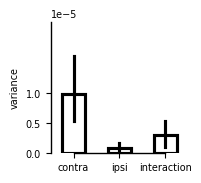

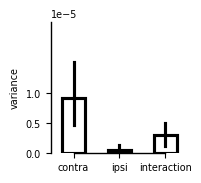

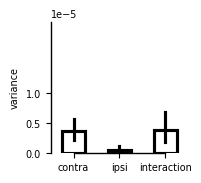

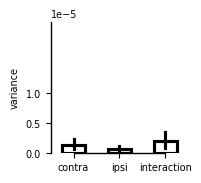

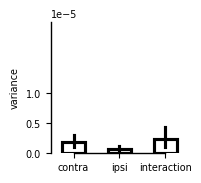

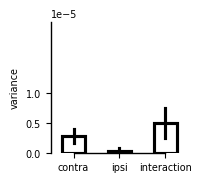

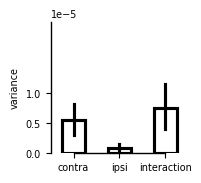

In [232]:
var_df = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_bimanual.csv'))
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp']

for region in regions:
    var_df_region = var_df[var_df['region'] == region]
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(figsize=(2,2))
    sns.barplot(x='component', y='variance', data=var_df_region, width=0.5, color='k', fill=False, ax=ax)
    ax.set_yticks(np.array([0, 0.5, 1.0])*1e-5)
    ax.set_ylim(0, 2.2e-5)
    plt.tight_layout()
    utils.please.make_it_pretty(ax=ax)
    ax.set_xlabel('')
    plt.savefig(f'../figures/VarDecompose/bimanual_{region}.pdf', bbox_inches="tight")
    plt.show()


### ANOVA on components

In [100]:
from statsmodels.stats.anova import AnovaRM
# rm anova on var_df:
anova = AnovaRM(var_df, 'variance', subject='sn', within=['component']).fit()
print(anova)
# Extract p-values with scientific notation
# print("\nP-values in scientific notation:")
# for index, row in anova.anova_table.iterrows():
#     print(f"{index}: F = {row['F Value']:.4f}, p = {row['Pr > F']:.3e}")

# post-hoc t-tests:
# contra vs ipsi
t_stat, p_val = stats.ttest_rel(var_contra, var_ipsi, alternative='two-sided')
print(f'\ncontra vs ipsi: t = {t_stat:.4f}, p = {p_val:.3e}')
# contra vs interaction
t_stat, p_val = stats.ttest_rel(var_contra, var_interaction, alternative='two-sided')
print(f'contra vs interaction: t = {t_stat:.4f}, p = {p_val:.3e}')
# ipsi vs interaction
t_stat, p_val = stats.ttest_rel(var_ipsi, var_interaction, alternative='two-sided')
print(f'ipsi vs interaction: t = {t_stat:.4f}, p = {p_val:.3e}')

# t-test component > 0:
t_stat, p_val = stats.ttest_1samp(var_contra, 0, alternative='greater')
print(f'\ncontra > 0: t = {t_stat:.4f}, p = {p_val:.3e}')
t_stat, p_val = stats.ttest_1samp(var_ipsi, 0, alternative='greater')
print(f'ipsi > 0: t = {t_stat:.4f}, p = {p_val:.3e}')
t_stat, p_val = stats.ttest_1samp(var_interaction, 0, alternative='greater')
print(f'interaction > 0: t = {t_stat:.4f}, p = {p_val:.3e}')



                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
component  8.6425 2.0000 46.0000 0.0007


contra vs ipsi: t = 3.2583, p = 3.460e-03
contra vs interaction: t = 2.6278, p = 1.504e-02
ipsi vs interaction: t = -2.2496, p = 3.435e-02

contra > 0: t = 3.4609, p = 1.060e-03
ipsi > 0: t = 1.6974, p = 5.156e-02
interaction > 0: t = 2.9437, p = 3.646e-03


## Unimanual

decomposing the unimanual activity patterns into contra and ipsi

### load dataset

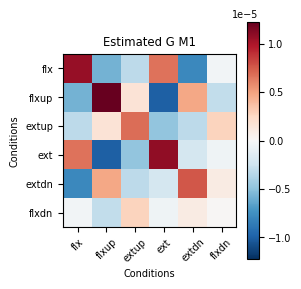

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
ncond = 6

# load dataset:
file_path_save = os.path.join(analysisDir, f'pcm_dataset_6by6_{region}.npz')
D = np.load(file_path_save, allow_pickle=True)
identifier = D['identifier']
D = D['Y'].tolist()

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

# visualize the estimated G:
G_mean = np.mean(G_hat[0:48,:,:], axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Estimated G {region}')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()



### variance of components

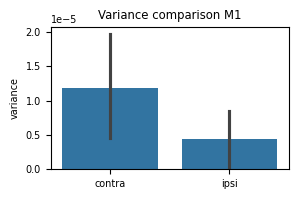

In [201]:
contra_idx = (identifier == 'contra').flatten()
ipsi_idx = (identifier == 'ipsi').flatten()

contra_G = G_hat[contra_idx,:,:]
ipsi_G = G_hat[ipsi_idx,:,:]

# variance measurement:
var_df = {'sn': [], 'component': [], 'variance': []}
for i in range(contra_G.shape[0]):
    var_df['sn'].append(i)
    var_df['component'].append('contra')
    var_df['variance'].append(np.trace(contra_G[i,:,:])/ncond)
    
    var_df['sn'].append(i)
    var_df['component'].append('ipsi')
    var_df['variance'].append(np.trace(ipsi_G[i,:,:])/ncond)
var_df = pd.DataFrame(var_df)

# barplot:
fig, ax = plt.subplots(figsize=(3,2))
sns.barplot(x='component', y='variance', data=var_df, ax=ax)
plt.title(f'Variance comparison {region}')
plt.xlabel('')
plt.tight_layout()
plt.show()



### run all regions

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
ncond = 6

var_df = {'region': [], 'sn': [], 'component': [], 'variance': []}
for region in regions:
    # load dataset:
    file_path_save = os.path.join(analysisDir, f'pcm_dataset_6by6_{region}.npz')
    D = np.load(file_path_save, allow_pickle=True)
    identifier = D['identifier']
    D = D['Y'].tolist()

    N = len(D)
    G_hat = np.zeros((N, ncond, ncond))
    Dist = np.zeros((N,ncond,ncond))
    for i in range(N):
        G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                                D[i].obs_descriptors['cond_vec'],
                                                D[i].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

    contra_idx = (identifier == 'contra').flatten()
    ipsi_idx = (identifier == 'ipsi').flatten()

    contra_G = G_hat[contra_idx,:,:]
    ipsi_G = G_hat[ipsi_idx,:,:]

    # variance measurement:
    for i in range(contra_G.shape[0]):
        var_df['region'].append(region)
        var_df['sn'].append(i)
        var_df['component'].append('contra')
        var_df['variance'].append(np.trace(contra_G[i,:,:])/ncond)
        
        var_df['region'].append(region)
        var_df['sn'].append(i)
        var_df['component'].append('ipsi')
        var_df['variance'].append(np.trace(ipsi_G[i,:,:])/ncond)
    
var_df = pd.DataFrame(var_df)
var_df.to_csv(os.path.join(analysisDir, 'VarDecompose_unimanual.csv'), index=False)    



### plot

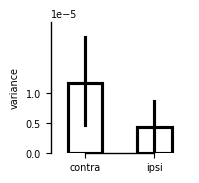

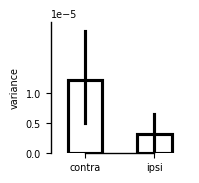

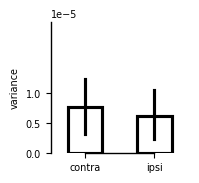

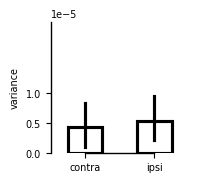

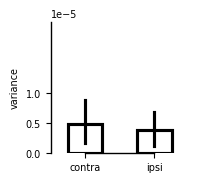

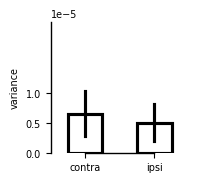

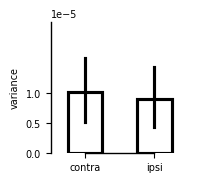

In [230]:
var_df = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_unimanual.csv'))
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp']

for region in regions:
    var_df_region = var_df[var_df['region'] == region]
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(figsize=(2,2))
    sns.barplot(x='component', y='variance', data=var_df_region, width=0.5, color='k', fill=False, ax=ax)
    ax.set_yticks(np.array([0, 0.5, 1.0])*1e-5)
    ax.set_ylim(0, 2.2e-5)
    plt.tight_layout()
    utils.please.make_it_pretty(ax=ax)
    ax.set_xlabel('')
    plt.savefig(f'../figures/VarDecompose/unimanual_{region}.pdf', bbox_inches="tight")
    plt.show()

